# Unet Implementation

In [64]:
import pickle
import gzip
import numpy as np
import os
import time
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import segmentation_models_pytorch as smp
from matplotlib import pyplot as plt
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [65]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

### Helper functions

In [66]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [67]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)
        
def flatten(dicts):
    
    # extract the annotated video frames, their labels
    # and the boxes
    
    images = []
    boxes = []
    labels = []
    
    for i, dic in enumerate(dicts):
        
        video = dic['video']
        frames = dic['frames']
        dic_labels = dic['label']
        
        images.append((video[:,:,frames[0]] / 255).astype('float32'))
        images.append((video[:,:,frames[1]] / 255).astype('float32'))
        images.append((video[:,:,frames[2]] / 255).astype('float32'))
        
        labels.append(dic_labels[:,:,frames[0]].astype('float32'))
        labels.append(dic_labels[:,:,frames[1]].astype('float32'))
        labels.append(dic_labels[:,:,frames[2]].astype('float32'))
        
    return images, labels

class SegDataset(Dataset):
    
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.labels[idx]
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        return image, mask

### Load data

In [5]:
# load data
train_data = load_zipped_pickle("data/train.pkl")
test_data = load_zipped_pickle("data/test.pkl")

In [6]:
size = (128, 128)

### Preprocessing

In [79]:
# turn dictionaries into lists of images and labels
images, labels = flatten(train_data)
# last 19 are expert images, take 6 of them to form validation dataset
train_images, train_labels = images[:177], labels[:177]
val_images, val_labels = images[177:], labels[177:]

### Augmentation

In [80]:
train_aug = A.Compose(
    [
        A.Resize(128, 128),
        A.augmentations.geometric.transforms.Affine(
            scale=(0.7, 1.3), 
            translate_percent=(0,0.1), 
            rotate=(-30,30), 
            shear=(-20, 20), 
            p=1)
    ]
)

train_to_tensor = A.Compose(
    [
        A.Resize(128,128),
        ToTensorV2()
    ]

)
val_to_tensor = A.Compose(
    [
        A.Resize(128, 128),
        ToTensorV2()
    ]
)

In [81]:
train_images = train_images * 6
train_labels = train_labels * 6

In [82]:
for i in range(len(train_images) // 8, len(train_images)):
    transformed = train_aug(image=train_images[i], mask=train_labels[i])
    train_images[i] = transformed["image"]
    train_labels[i] = transformed["mask"]

In [89]:
train_dataset = SegDataset(train_images, train_labels, train_to_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, pin_memory=True, shuffle=True)
val_dataset = SegDataset(val_images, val_labels, val_to_tensor)
val_loader = DataLoader(val_dataset, batch_size=6, pin_memory=True)

### Model

In [90]:
class Unet(nn.Module):
    
    def __init__(self, filters=64):
        
        super().__init__()
        
        # following advice of the TA, first only with 3 encoder
        # and 3 decoder blocks instead of 4 as in the paper
        
        self.max_pool = nn.MaxPool2d(2)
        
        self.block_enc_1 = self.conv_block(1, filters)
        self.block_enc_2 = self.conv_block(filters, 2*filters)
        self.block_enc_3 = self.conv_block(2*filters, 4*filters)
        
        self.block_inbetween = self.conv_block(4*filters, 8*filters, True)
        
        self.block_dec_1 = self.conv_block(8*filters, 4*filters, True)
        self.block_dec_2 = self.conv_block(4*filters, 2*filters, True)
        
        self.block_last = self.conv_block(2*filters, filters, True, True)
        
    def conv_block(self, channels, filters, dec=False, last=False):
        
        modules = []
        
        if not dec:
            modules.append(nn.Dropout(p=0.5))
        
        modules.append(nn.Conv2d(channels, filters, 3, 1, padding='same'))
        modules.append(nn.ReLU())
        modules.append(nn.Conv2d(filters, filters, 3, 1, padding='same'))
        modules.append(nn.ReLU())
        
        # if not decoder, then we add upscaling layer
        # if last layer, then we add conv 1x1 and sigmoid to get logits in (0, 1)
        if dec:
            if not last:
                modules.append(nn.ConvTranspose2d(filters, filters//2, 2, stride=(2,2)))
            else:
                modules.append(nn.Conv2d(filters, 1, 1, 1))
                modules.append(nn.Sigmoid())
            
        return nn.Sequential(*modules)
            
    def forward(self, x):
        
        # encoder
        
        x1 = self.block_enc_1(x)
        x2 = self.max_pool(x1)
        
        x3 = self.block_enc_2(x2)
        x4 = self.max_pool(x3)
        
        x5 = self.block_enc_3(x4)
        x6 = self.max_pool(x5)
        
        # between encoder and decoder
        
        x7 = self.block_inbetween(x6)
        
        # decoder
        
        x8 = self.block_dec_1(torch.cat((x7, x5), dim=1))
        x9 = self.block_dec_2(torch.cat((x8, x3), dim=1))
        
        x10 = self.block_last(torch.cat((x9, x1), dim=1))
        
        return x10

### Train

In [91]:
def iou_metric(inputs, targets):       
        
        # remove channel dimension (C = 1) with squeeze
        inputs = inputs.squeeze()
        
        # round to 0 or 1
        inputs = torch.round(inputs)
        
        # get intersection and union
        intersection = (inputs * targets).sum(dim=(1, 2))
        total = (inputs + targets).sum(dim=(1, 2))
        union = total - intersection 
        
        IoU = intersection / union
                
        return IoU

In [92]:
def evaluate(model, val_loader):
    
    val_iou_list = torch.Tensor().to(device)
    
    for x,y in val_loader:
        
        x,y = x.to(device), y.to(device)
        output = unet(x)
        val_iou_list = torch.cat((val_iou_list, iou_metric(output, y)))
    
    return torch.median(val_iou_list)

In [102]:
unet = Unet(filters=16).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=5e-5)
#criterion = smp.losses.FocalLoss(mode='binary')
criterion = smp.losses.JaccardLoss(mode='binary')

### Train Loop

In [103]:
val_ious = []
train_ious = []

for epoch in range(1,300):
    
    t = time.time()
    num_samples_epoch = 0
    train_loss_cum = 0
    train_iou_list = torch.Tensor().to(device)
    
    for x,y in train_loader:
        
        x,y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        unet.train()
        
        output = unet(x)
        loss = criterion(output.squeeze(), y) # + criterion2(output.squeeze(), y)
        
        loss.backward()
        optimizer.step()
        
        # keep track of training loss
        num_samples_epoch += x.shape[0]
        train_loss_cum += loss * x.shape[0]
        
        # calculate train IoU scores and concat
        unet.eval()
        with torch.no_grad():
            train_iou_list = torch.cat((train_iou_list, iou_metric(output, y)))
    
    # get median IoU on validation data
    with torch.no_grad():
        val_iou = evaluate(unet, val_loader)
            
    # average train_loss
    train_loss = train_loss_cum / num_samples_epoch
    
    # get median IoU on train data
    train_iou = torch.median(train_iou_list)   
    
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    
    epoch_duration = time.time() - t

    print(f'Epoch {epoch} | Train IoU: {train_iou:.4f} | '
          f'Train loss: {train_loss:.4f} | '
          f' Validation IoU: {val_iou:.4f} | '
          f' Duration {epoch_duration:.2f} sec')

Epoch 1 | Train IoU: 0.0142 | Train loss: 0.9911 |  Validation IoU: 0.0213 |  Duration 8.65 sec
Epoch 2 | Train IoU: 0.0360 | Train loss: 0.9890 |  Validation IoU: 0.0338 |  Duration 8.36 sec
Epoch 3 | Train IoU: 0.0721 | Train loss: 0.9883 |  Validation IoU: 0.0898 |  Duration 8.31 sec
Epoch 4 | Train IoU: 0.0835 | Train loss: 0.9882 |  Validation IoU: 0.0848 |  Duration 8.32 sec
Epoch 5 | Train IoU: 0.0907 | Train loss: 0.9881 |  Validation IoU: 0.0909 |  Duration 8.35 sec
Epoch 6 | Train IoU: 0.0984 | Train loss: 0.9881 |  Validation IoU: 0.1232 |  Duration 8.34 sec
Epoch 7 | Train IoU: 0.1049 | Train loss: 0.9880 |  Validation IoU: 0.0892 |  Duration 8.36 sec
Epoch 8 | Train IoU: 0.1127 | Train loss: 0.9879 |  Validation IoU: 0.1852 |  Duration 8.37 sec
Epoch 9 | Train IoU: 0.1167 | Train loss: 0.9879 |  Validation IoU: 0.1765 |  Duration 8.34 sec
Epoch 10 | Train IoU: 0.1171 | Train loss: 0.9879 |  Validation IoU: 0.2060 |  Duration 8.31 sec
Epoch 11 | Train IoU: 0.1304 | Train lo

Epoch 86 | Train IoU: 0.2963 | Train loss: 0.9875 |  Validation IoU: 0.2388 |  Duration 8.45 sec
Epoch 87 | Train IoU: 0.2928 | Train loss: 0.9875 |  Validation IoU: 0.3333 |  Duration 8.45 sec
Epoch 88 | Train IoU: 0.2959 | Train loss: 0.9875 |  Validation IoU: 0.2839 |  Duration 8.45 sec
Epoch 89 | Train IoU: 0.2946 | Train loss: 0.9875 |  Validation IoU: 0.2270 |  Duration 8.45 sec
Epoch 90 | Train IoU: 0.2899 | Train loss: 0.9875 |  Validation IoU: 0.2532 |  Duration 8.47 sec
Epoch 91 | Train IoU: 0.2941 | Train loss: 0.9875 |  Validation IoU: 0.2671 |  Duration 8.46 sec
Epoch 92 | Train IoU: 0.2951 | Train loss: 0.9875 |  Validation IoU: 0.2344 |  Duration 8.46 sec
Epoch 93 | Train IoU: 0.3056 | Train loss: 0.9875 |  Validation IoU: 0.2276 |  Duration 8.44 sec
Epoch 94 | Train IoU: 0.3055 | Train loss: 0.9875 |  Validation IoU: 0.2715 |  Duration 8.45 sec
Epoch 95 | Train IoU: 0.3031 | Train loss: 0.9875 |  Validation IoU: 0.2920 |  Duration 8.45 sec
Epoch 96 | Train IoU: 0.3085 |

Epoch 170 | Train IoU: 0.3440 | Train loss: 0.9874 |  Validation IoU: 0.2913 |  Duration 8.45 sec
Epoch 171 | Train IoU: 0.3544 | Train loss: 0.9874 |  Validation IoU: 0.3465 |  Duration 8.45 sec
Epoch 172 | Train IoU: 0.3599 | Train loss: 0.9874 |  Validation IoU: 0.3011 |  Duration 8.45 sec
Epoch 173 | Train IoU: 0.3594 | Train loss: 0.9874 |  Validation IoU: 0.3142 |  Duration 8.47 sec
Epoch 174 | Train IoU: 0.3616 | Train loss: 0.9874 |  Validation IoU: 0.2545 |  Duration 8.44 sec
Epoch 175 | Train IoU: 0.3657 | Train loss: 0.9874 |  Validation IoU: 0.2551 |  Duration 8.45 sec
Epoch 176 | Train IoU: 0.3609 | Train loss: 0.9874 |  Validation IoU: 0.3018 |  Duration 8.43 sec
Epoch 177 | Train IoU: 0.3577 | Train loss: 0.9874 |  Validation IoU: 0.3584 |  Duration 8.46 sec
Epoch 178 | Train IoU: 0.3625 | Train loss: 0.9874 |  Validation IoU: 0.2740 |  Duration 8.45 sec
Epoch 179 | Train IoU: 0.3619 | Train loss: 0.9874 |  Validation IoU: 0.3273 |  Duration 8.43 sec
Epoch 180 | Train Io

Epoch 254 | Train IoU: 0.3953 | Train loss: 0.9874 |  Validation IoU: 0.2755 |  Duration 8.42 sec
Epoch 255 | Train IoU: 0.3984 | Train loss: 0.9874 |  Validation IoU: 0.2653 |  Duration 8.44 sec
Epoch 256 | Train IoU: 0.4021 | Train loss: 0.9874 |  Validation IoU: 0.1797 |  Duration 8.43 sec
Epoch 257 | Train IoU: 0.4000 | Train loss: 0.9874 |  Validation IoU: 0.0426 |  Duration 8.47 sec
Epoch 258 | Train IoU: 0.3989 | Train loss: 0.9874 |  Validation IoU: 0.0000 |  Duration 8.43 sec
Epoch 259 | Train IoU: 0.3879 | Train loss: 0.9874 |  Validation IoU: 0.1961 |  Duration 8.47 sec
Epoch 260 | Train IoU: 0.4036 | Train loss: 0.9874 |  Validation IoU: 0.0787 |  Duration 8.45 sec
Epoch 261 | Train IoU: 0.3874 | Train loss: 0.9874 |  Validation IoU: 0.0638 |  Duration 8.44 sec
Epoch 262 | Train IoU: 0.4063 | Train loss: 0.9874 |  Validation IoU: 0.0000 |  Duration 8.45 sec
Epoch 263 | Train IoU: 0.3935 | Train loss: 0.9874 |  Validation IoU: 0.0000 |  Duration 8.48 sec
Epoch 264 | Train Io

### Visualizing some results

In [ ]:
# shows summary of model like in tensorflow
summary = summary(unet, (1, 128, 128))

In [109]:
for i in range(len(train_ious)):
    train_ious[i] = train_ious[i].cpu().numpy()
    val_ious[i] = val_ious[i].cpu().numpy()

In [114]:
# mean
mean_5_val_ious = []
for i in range(len(val_ious) // 5):
    mean_5_val_ious.append(np.mean(val_ious[i*5:(i+1)*5]))

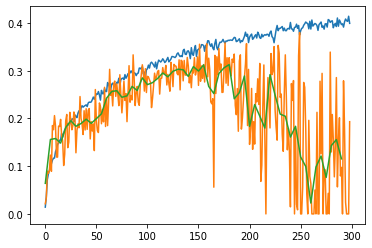

In [121]:
plt.plot(np.arange(len(train_ious)), train_ious)
plt.plot(np.arange(len(train_ious)), val_ious)
plt.plot(np.arange(0, 295, 5), mean_5_val_ious)

In [ ]:
unet = unet.to('cpu')
X_vis = train_images[:5]
y_vis = train_labels[:5]
res = unet(torch.from_numpy(X_vis))

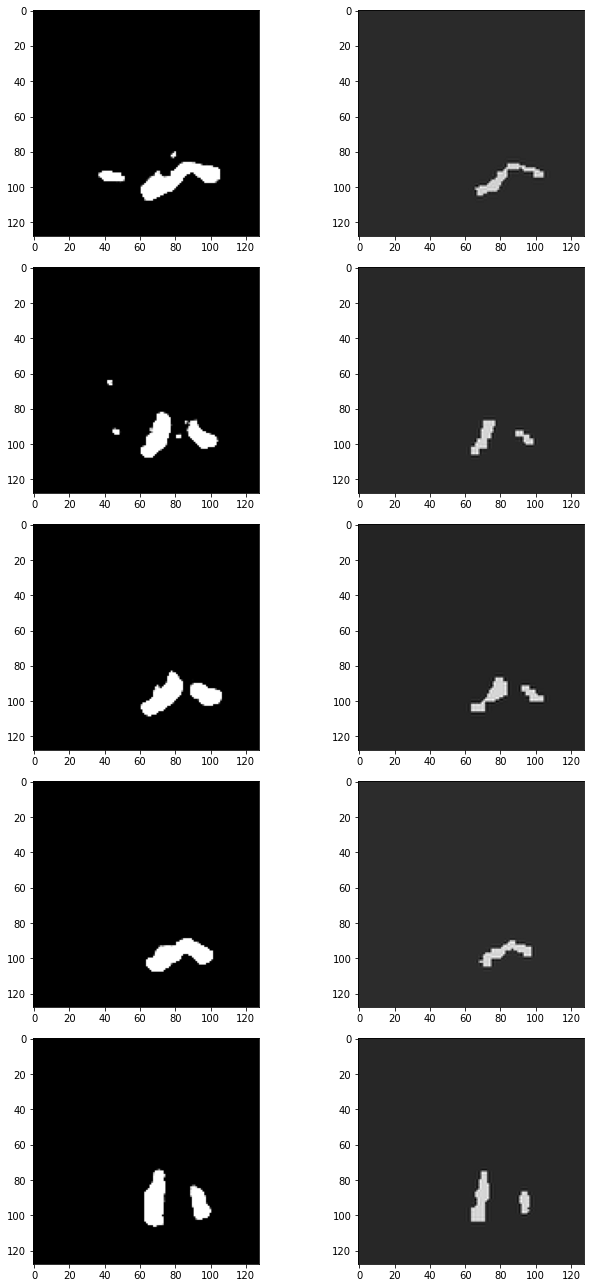

In [16]:
fig, ax = plt.subplots(5,3)
fig.set_figheight(18)
fig.set_figwidth(10)
for i in range(res.shape[0]):
    
    ax[i,0].imshow(res[i].squeeze().cpu().detach().numpy(), cmap='gray')
    ax[i,1].imshow(y_vis[i].squeeze().cpu().detach().numpy(), cmap='gray')
    ax[i,1].imshow(y_vis[i].squeeze().cpu().detach().numpy(), cmap='gray')
plt.tight_layout()

In [120]:
np.arange(0, 295, 5).shape

(59,)